In [1]:
import tensorflow as tf
import pyautogui
import pydirectinput
from PIL import Image, ImageEnhance
from tensorflow import keras
from keras.models import Sequential,load_model
from keras.layers import Conv2D , Dense ,Activation,BatchNormalization,MaxPooling2D,Flatten,Input
import numpy as np
import time
import keyboard
# import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [3]:
class mk:
    def __init__(self):
        self.memory = []
        
        self.gamma = 0.95  # use in q*(s,a) = Rt+1 + gamma*(max q*(s,a))
        
        self.epsilon = 0.9                   # use in exploration vs exploitation
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        
        self.learning_rate = 0.001     
        
        self.alpha = 0.01
        
        self.unique_colors = []
        
        self.health = 0
        self.opponent_health = 0
        self.energy = 0
        
        self.action = []
        self.holding = False
        
        self.episodes=0

        # Define Actions
        self.actions = [
            ['w','w','w'],
            ['w','w'],
            ['w','w','s'],
            ['e','w','e'],
            ['left','e','w','s'],
            ['a','a','s'],
            ['right','right'],
            ['left','up'],
            ['right','up'],
            ['w'],
            ['e'],
            ['a'],
            ['s'],
            ['left', 'w'],
            ['down', 'e'],
            ['left', 'e'],
            ['right', 's'],
            ['right', 'e'],
            ['left', 's'],
            ['left', 'a'],
            ['r'],
            ['right', 'r'],
            ['w', 'e'],
            ['down', 'right', 'a'],
            ['left', 'right', 's'],
            ['down', 'right', 's'],
            ['down', 'left', 'w'],
            ['down', 'left', 'a'],
            ['space'],
            # ['lshift', 'space'] # When Energy is full
        ]

        self.model = self._build_model()
        self.target_model = self._build_model()
        # self.model = load_model('DQN_MODEL_FOR_MK_TEST.keras')
        # self.target_model= load_model('DQN_MODEL_FOR_MK_TEST.keras')
        self.action = []
        self.prev_health = 100
        self.opponent_prev_health = 100

        # Original image dimensions
        self.image_width = 1280
        self.image_height = 720

        # New screen dimensions
        # time.sleep(5)
        self.new_image = pyautogui.screenshot()
        self.screen_width, self.screen_height = self.new_image.size

        # Calculate ratios
        self.width_ratio = self.screen_width / self.image_width
        self.height_ratio = self.screen_height / self.image_height

        # self.width_ratio = 1
        # self.height_ratio = 1

        # Original agent cropped rectangle coordinates
        self.agent_crop_left = 125
        self.agent_crop_top = 75
        self.agent_crop_right = 599
        self.agent_crop_bottom = 89

        # Original enemy cropped rectangle coordinates
        self.enemy_crop_left = 680
        self.enemy_crop_top = 75
        self.enemy_crop_right = 1154
        self.enemy_crop_bottom = 89

        # Agent energy bar reactangle coordinates
        self.energy_crop_left = 160
        self.energy_crop_top = 651
        self.energy_crop_right = 395
        self.energy_crop_bottom = 659

        # Scale the cropped rectangle coordinates
        self.agent_crop_left = int(self.agent_crop_left * self.width_ratio)
        self.agent_crop_top = int(self.agent_crop_top * self.height_ratio)
        self.agent_crop_right = int(self.agent_crop_right * self.width_ratio)
        self.agent_crop_bottom = int(self.agent_crop_bottom * self.height_ratio)

        self.enemy_crop_left = int(self.enemy_crop_left * self.width_ratio)
        self.enemy_crop_top = int(self.enemy_crop_top * self.height_ratio)
        self.enemy_crop_right = int(self.enemy_crop_right * self.width_ratio)
        self.enemy_crop_bottom = int(self.enemy_crop_bottom * self.height_ratio)

        self.energy_crop_left = int(self.energy_crop_left * self.width_ratio)
        self.energy_crop_top = int(self.energy_crop_top * self.height_ratio)
        self.energy_crop_right = int(self.energy_crop_right * self.width_ratio)
        self.energy_crop_bottom = int(self.energy_crop_bottom * self.height_ratio)

    def _build_model(self):
        model = Sequential()
        model.add(Input(shape=(200, 300, 1)))
        model.add(Conv2D(16, (3, 3), 1, activation='relu'))
        model.add(Conv2D(16, (3, 3), 1, activation='relu'))
        model.add(MaxPooling2D())
        model.add(Conv2D(16, (3, 3), 1, activation='relu'))
        model.add(Conv2D(16, (3, 3), 1, activation='relu'))
        model.add(MaxPooling2D())
        model.add(Flatten())
        model.add(Dense(200, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dense(len(self.actions), activation='softmax'))
        model.compile(optimizer='adam', loss='categorical_crossentropy')
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def get_index(self, action):
        for i, value in enumerate(self.actions):
            if value == action:
                return i
        return -1

    def replay(self, batch_size):
        for i in range(20):
            print("Episode : ", (i + 1))
            minibatch = np.random.choice(len(self.memory), batch_size, replace=False)
            for index in minibatch:
                state, action, reward, next_state, done = self.memory[index]
                target = reward
                if not done:
                    target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
                target_f = self.model.predict(state)
                target_f[0][action] = target_f[0][action] + self.alpha * target
                # state = np.expand_dims(state, axis=0)
                self.model.fit(state, target_f, epochs=1, verbose=0)

            if i % 10 == 0:
                self.model.save('DQN_MODEL_FOR_MK_300520240641PM.keras')
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        clear_output()

    def get_health(self, image):
        pixel_count = 0
        width, height = image.size
        for y in range(height):
            for x in range(width):
                r, g, b = image.getpixel((x, y))
                if (r, g, b) in image:
                    pixel_count += 1
        int(pixel_count / 450 * 100)

    def map_values(self, x):
        # Ensure x is within the range [5, 99]
        x = max(5, min(x, 99))

        # Map the range [5, 99] to [0, 100]
        return int(((x - 5) / (99 - 5)) * 100)

    def calculate_percentage(self, state, state2):
        state1 = np.array(state)
        state2 = np.array(state2)

        diff = state1 - state2
        img = Image.fromarray(diff)
        pixels = img.load()
        for i in range(img.size[0]):  # for every pixel:
            for j in range(img.size[1]):
                if pixels[i, j] != (0, 0, 0):
                    pixels[i, j] = (255, 255, 255)

        # Show the image using OpenCV
        img_gray = img.convert('L')

        # Get pixel values as a NumPy array
        pixel_values = np.array(img_gray)
        # Count occurrences of black pixels (0)
        num_black_pixels = np.sum(pixel_values == 0)

        # Calculate percentage of black pixels
        total_pixels = img_gray.width * img_gray.height
        percentage_black_pixels = (num_black_pixels / total_pixels) * 100

        return self.map_values(percentage_black_pixels)

    # def process_image(image, crop_left, crop_top, crop_right, crop_bottom):

    #     # Crop the image to the desired region
    #     cropped_image = image.crop((crop_left, crop_top, crop_right, crop_bottom))
    #     return cropped_image

    def calculate_energy(self, energy):
        energy = energy.convert('L')
        energy_arr = np.array(energy)
        total_pixels = energy.width * energy.height
        white_pixels = np.sum(energy_arr >= 100)
        percentage = white_pixels / total_pixels * 100
        return percentage

    def act(self):

        # Process Agent images
        image1 = pyautogui.screenshot()
        state = image1
        state=state.crop((0,100,image1.width,image1.height-100))
        state = state.convert('L')
        state = state.resize((300, 200))
        state = np.array(state)
        state = state / 255.0

        if np.random.rand() <= self.epsilon:
            action_index= np.random.choice(len(self.actions))
            # printing action
            # print('Action_Index: ', action_index)
        else:
            q_values = self.model.predict(np.array([state]))
            action_index = np.argmax(q_values[0])
            # print(' ---- Action_Index: ', action_index)

        action = self.actions[action_index]

        # if self.energy >= 90:
        #     pydirectinput.keyDown('shift')
        #     pydirectinput.keyDown('space')
        #     time.sleep(0.1)
        #     pydirectinput.keyUp('shift')
        #     pydirectinput.keyUp('space')
        #     print('Energy is Full')

        if action_index <6:
            for act in action:
                pydirectinput.keyDown(act)
                time.sleep(0.001)
                pydirectinput.keyUp(act)
        else:
            for act in action:
                pydirectinput.keyDown(act)
            time.sleep(0.001)
            for act in action:
                pydirectinput.keyUp(act)

        image2 = pyautogui.screenshot()

        # Crop Agent health
        agent1_image = image1.crop(
            (self.agent_crop_left, self.agent_crop_top, self.agent_crop_right, self.agent_crop_bottom))
        agent2_image = image2.crop(
            (self.agent_crop_left, self.agent_crop_top, self.agent_crop_right, self.agent_crop_bottom))

        # agent1_image.save('agent1_image.png')
        # agent2_image.save('agent2_image.png')

        # Crop Enemy health
        enemy1_image = image1.crop(
            (self.enemy_crop_left, self.enemy_crop_top, self.enemy_crop_right, self.enemy_crop_bottom))
        enemy2_image = image2.crop(
            (self.enemy_crop_left, self.enemy_crop_top, self.enemy_crop_right, self.enemy_crop_bottom))

        # enemy1_image.save('enemy1_image.png')
        # enemy2_image.save('enemy2_image.png')

        # Crop Energy health
        # energy1_image = image1.crop(
        #     (self.energy_crop_left, self.energy_crop_top, self.energy_crop_right, self.energy_crop_bottom))
        
        # energy2_image = image2.crop(
        #     (self.energy_crop_left, self.energy_crop_top, self.energy_crop_right, self.energy_crop_bottom))

        # Calculate in percentage
        agent = self.calculate_percentage(agent1_image, agent2_image)
        enemy = self.calculate_percentage(enemy1_image, enemy2_image)
        # energy = self.calculate_energy(energy2_image)



        next_state = image2
        next_state=next_state.crop((0,100,image1.width,image1.height-100))
        # Health -----------------
        # health_image=next_state.crop(health_region)
        # opponent_health_image=next_state.crop(opponent_health_region)

        next_state = next_state.convert('L')
        next_state = next_state.resize((300, 200))
        next_state = np.array(next_state)
        next_state = next_state / 255.0

        self.health = agent
        self.opponent_health = enemy
        # self.energy = energy

        reward = 0
        done = False
        if self.health <= 0 or self.opponent_health <= 0:
            done = True
        # print("opponent_health : " ,self.opponent_health,"eweeaesr  rwe ssrropponent_prev_health : ",self.opponent_prev_health)
        # print("health : ", self.health, " prev_health : ", self.prev_health)

        if self.opponent_health < self.opponent_prev_health:
            reward = int(self.opponent_prev_health - self.opponent_health)
            self.opponent_prev_health = self.opponent_health
        if self.health < self.prev_health:
            reward -= self.prev_health - self.health
            self.prev_health = self.health

        return state, self.get_index(action), reward, next_state, done

    def play(self):
        print('Playing...')
        time.sleep(3)

        for i in range(2):
            done = False
            self.episodes=0
            while self.episodes<5:
                state, action, reward, next_state, done = self.act()
                if reward<=20:
                    self.remember(np.array([state]), action, reward / 10, np.array([next_state]), done)
                    print('Agent: ', self.health, ' | Enemy: ', self.opponent_health, 'Energy: ', self.energy, ' | Reward: ', reward)
                    if done:
                        self.episodes=self.episodes+1
                        self.opponent_prev_health=100
                        self.prev_health=100
                        pydirectinput.keyDown('k')
                        pydirectinput.keyUp('k')
        if len(self.memory) > 32:
            print(len(self.memory))
            self.replay(32)
                

        

    # def play(self):
    #         print('Playing...')
    #         time.sleep(3)
            
    #         done = False
    #         while not done:
    #             state, action, reward, next_state, done = self.act()
    #             self.remember(np.array([state]), action, reward / 10, np.array([next_state]), done)
    #             print('Agent: ', self.health, ' | Enemy: ', self.opponent_health, 'Energy: ', self.energy, ' | Reward: ', reward)
    #             if done:
    #                 self.opponent_prev_health=100
    #                 self.prev_health=100
    
    #         if len(self.memory) > 64:
    #             print(len(self.memory))
    #             self.replay(32)
    #         print('Done Playing...')


In [5]:
agent=mk()

In [ ]:
agent.play()

Playing...
Agent:  100  | Enemy:  100 Energy:  0  | Reward:  0
Agent:  99  | Enemy:  100 Energy:  0  | Reward:  -1
Agent:  99  | Enemy:  96 Energy:  0  | Reward:  4
Agent:  99  | Enemy:  97 Energy:  0  | Reward:  0
Agent:  100  | Enemy:  78 Energy:  0  | Reward:  18
Agent:  100  | Enemy:  86 Energy:  0  | Reward:  0
Agent:  100  | Enemy:  94 Energy:  0  | Reward:  0
Agent:  100  | Enemy:  81 Energy:  0  | Reward:  0
Agent:  100  | Enemy:  87 Energy:  0  | Reward:  0
Agent:  99  | Enemy:  79 Energy:  0  | Reward:  0
Agent:  99  | Enemy:  79 Energy:  0  | Reward:  0
Agent:  99  | Enemy:  80 Energy:  0  | Reward:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
Agent:  99  | Enemy:  70 Energy:  0  | Reward:  8
Agent:  99  | Enemy:  76 Energy:  0  | Reward:  0
Agent:  100  | Enemy:  71 Energy:  0  | Reward:  0
Agent:  99  | Enemy:  71 Energy:  0  | Reward:  0
Agent:  100  | Enemy:  55 Energy:  0  | Reward:  15
Agent:  99  | Enemy:  63 Energy:  0  | Reward:  0
Agent:  99  | Enemy:  65 Energy:  0  

In [34]:
len(agent.actions)

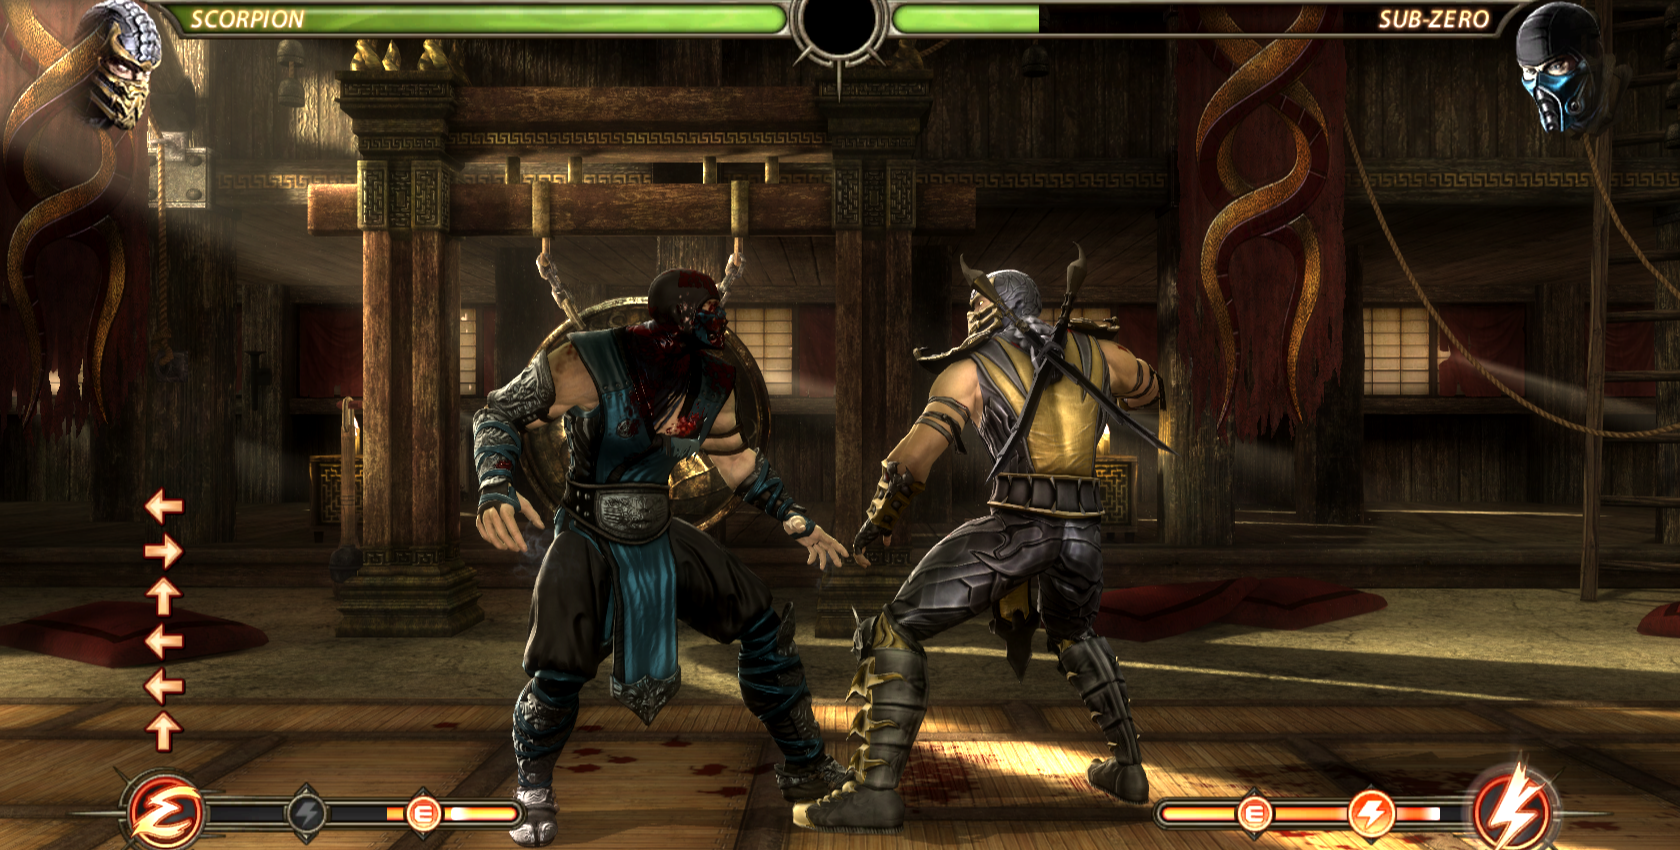

In [34]:
time.sleep(3)
image1 = pyautogui.screenshot()
image1=image1.crop((0,100,image1.width,image1.height-100))
image1